# **Import Package**

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *

# **Dataset Exploration**

In [2]:
df = pd.read_csv('/content/AMZN_2006-01-01_to_2018-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [3]:
date = df['Date'].values
price = df['Close'].values

## **Visualize Closing Price**

Text(0.5, 1.0, 'AMZN Stock Price')

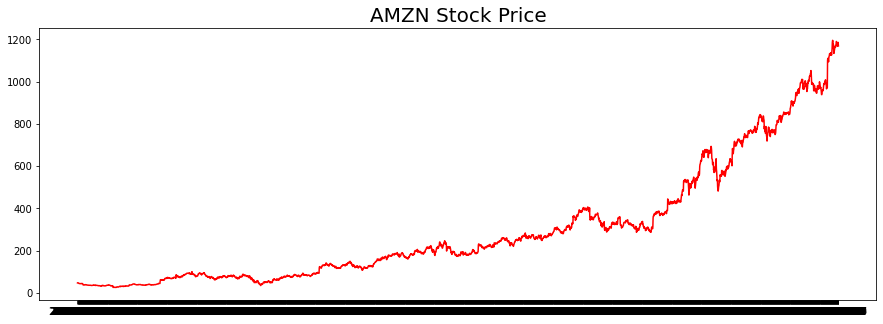

In [5]:
plt.figure(figsize=(15,5))
plt.plot(date, price, color = 'red', label = 'Real AMZN Stock Price')
plt.title('AMZN Stock Price',
          fontsize=20)

# **Preprocessing**

In [4]:
def test_size (percent):
  total = len(price)
  test = total*percent
  return round(test)

test_size(0.2)
train_size = len(price)-test_size(0.2)
train_size

2415

In [21]:
training_set = df.iloc[:train_size, 4:5].values
test_set = df.iloc[train_size:, 4:5].values

In [22]:
training_set

array([[ 47.58],
       [ 47.25],
       [ 47.65],
       ...,
       [537.01],
       [529.46],
       [522.62]])

In [23]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [24]:
window_size = 50

X_train = []
y_train = []

for i in range(window_size, train_size):
    X_train.append(training_set_scaled[i-window_size:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# **Model Initialization**

In [25]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [26]:
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < 0.1):
            print("MAE has reached below 10%")

    def on_train_end(self, epoch, logs={}):
        print('Done')

callbacks = my_callback()

# **Training**

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


history = model.fit(X_train, 
                    y_train, 
                    validation_split = 0.2,
                    callbacks = callbacks,
                    epochs = 100, 
                    batch_size = 32)

Epoch 1/100
60/60 [==============================] - 12s 87ms/step - loss: 0.0069 - mae: 0.0729 - val_loss: 0.0109 - val_mae: 0.1343
Epoch 2/100
60/60 [==============================] - 4s 60ms/step - loss: 5.6417e-04 - mae: 0.0249 - val_loss: 0.0013 - val_mae: 0.0384
Epoch 3/100
60/60 [==============================] - 4s 60ms/step - loss: 4.1510e-04 - mae: 0.0215 - val_loss: 0.0011 - val_mae: 0.0352
Epoch 4/100
60/60 [==============================] - 4s 60ms/step - loss: 4.8256e-04 - mae: 0.0237 - val_loss: 0.0010 - val_mae: 0.0330
Epoch 5/100
60/60 [==============================] - 4s 60ms/step - loss: 3.8019e-04 - mae: 0.0206 - val_loss: 0.0047 - val_mae: 0.0840
Epoch 6/100
60/60 [==============================] - 4s 60ms/step - loss: 4.2777e-04 - mae: 0.0227 - val_loss: 0.0021 - val_mae: 0.0505
Epoch 7/100
60/60 [==============================] - 4s 60ms/step - loss: 3.0149e-04 - mae: 0.0181 - val_loss: 0.0030 - val_mae: 0.0658
Epoch 8/100
60/60 [==============================] 

In [31]:
dataset_train = df.iloc[:train_size, 4:5]
dataset_test = df.iloc[train_size:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - window_size:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(window_size, test_size(0.2)):
    X_test.append(inputs[i-window_size:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(554, 50, 1)


In [32]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)